# Lezione 11

In [ ]:
from liblet import (
    Grammar, 
    Production, 
    Derivation,
    BottomUpInstantaneousDescription,
    Stack, 
    Queue, 
    Tree, 
    ProductionGraph,
    side_by_side,
    __version__
)
__version__

'1.3.3-alpha'

## Shift e reduce

In [ ]:
G = Grammar.from_string("""
S -> A C
A -> a b
C -> c
""")

i = BottomUpInstantaneousDescription(G, 'abc')
i

(), , a̲bc

In [ ]:
i = i.shift()
display(i, side_by_side(i.stack))

(), (a), ab̲c

In [ ]:
i = i.shift()
display(i, side_by_side(i.stack))

(), (b)(a), abc̲

In [ ]:
i = i.reduce(G.P[1])
display(i, side_by_side(i.stack))

(A -> a b,), (A: (a), (b)), abc̲

In [ ]:
i = i.shift()
display(i, side_by_side(i.stack))

(A -> a b,), (c)(A: (a), (b)), abc̲

In [ ]:
i = i.reduce(G.P[2])
display(i, side_by_side(i.stack))

(C -> c, A -> a b), (C: (c))(A: (a), (b)), abc̲

In [ ]:
i = i.reduce(G.P[0])
display(i, side_by_side(i.stack))

(S -> A C, C -> c, A -> a b), (S: (A: (a), (b)), (C: (c))), abc̲

## La funzione "stato prossimo"

In [ ]:
def next_instdescrs(curr):
 
    instdescrs = []

    # shift
    if curr.head_pos < len(curr.tape): instdescrs.append(curr.shift())

    # reduce
    tops = tuple(t.root for t in curr.stack)    
    for P in filter(Production.such_that(rhs_is_suffix_of = tops), curr.G.P):
        instdescrs.append(curr.reduce(P))

    return instdescrs

## Usando una visita in ampiezza

In [ ]:
def breadth_first(G, word, verbose = False, first_only = False):
    q = Queue()
    q.enqueue(BottomUpInstantaneousDescription(G, word))
    derivations = []
    while q:
        if verbose: 
            for i in q: display(side_by_side(i.stack))
            print('-' * 60)            
        curr = q.dequeue()
        if curr.is_done():
            derivations.append(curr.steps)
            if first_only: return derivations
        else:
            for nxt in next_instdescrs(curr): q.enqueue(nxt)
    return derivations

## Un esempio

In [ ]:
# fig. 7.4, pag. 201

G = Grammar.from_string('S -> a S b | S a b | a a a')
G

Grammar(N={S}, T={a, b}, P=(S -> a S b, S -> S a b, S -> a a a), S=S)

In [ ]:
derivations = breadth_first(G, list('aaaab'), True)

------------------------------------------------------------


------------------------------------------------------------


------------------------------------------------------------


------------------------------------------------------------


------------------------------------------------------------


------------------------------------------------------------


------------------------------------------------------------


------------------------------------------------------------


------------------------------------------------------------


------------------------------------------------------------


------------------------------------------------------------


------------------------------------------------------------


------------------------------------------------------------


In [ ]:
side_by_side([ProductionGraph(Derivation(G).rightmost(d)) for d in derivations])

## Usando una visita in profondità

In [ ]:
def depth_first(G, word, verbose = False):
    s = Stack()
    s.push(BottomUpInstantaneousDescription(G, word))
    derivations = []
    steps = 0
    while s:
        if verbose: 
            for i in s: display(side_by_side(i.stack))
            print('-' * 60)            
        curr = s.pop()
        if curr.is_done():
            derivations.append(curr.steps)
        else:
            for nxt in next_instdescrs(curr): s.push(nxt)
    return derivations

In [ ]:
derivations = depth_first(G, list('aaaab'), True)

------------------------------------------------------------


------------------------------------------------------------


------------------------------------------------------------


------------------------------------------------------------


------------------------------------------------------------


------------------------------------------------------------


------------------------------------------------------------


------------------------------------------------------------


------------------------------------------------------------


------------------------------------------------------------


------------------------------------------------------------


------------------------------------------------------------


------------------------------------------------------------


In [ ]:
side_by_side([ProductionGraph(Derivation(G).rightmost(d)) for d in derivations])

## Un caso maggiormente realistico

In [ ]:
# fig. 7.8, pag. 204

G = Grammar.from_string("""
S -> E
E -> E Q F | F
F -> a
Q -> + | -
""")
G

Grammar(N={E, F, Q, S}, T={+, -, a}, P=(S -> E, E -> E Q F, E -> F, F -> a, Q -> +, Q -> -), S=S)

In [ ]:
derivations = breadth_first(G, list('a-a+a')) # provate con verbose = True

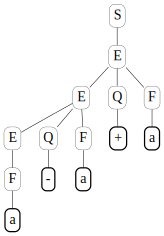

In [ ]:
ProductionGraph(Derivation(G).rightmost(derivations[0]))

# LLVM

Un paio di link per valutare se introdurre o meno LLVM nella seconda parte del corso

* [LLVM for Grad Students](https://www.cs.cornell.edu/~asampson/blog/llvm.html),
* [Writing your own programming language and compiler with Python](https://blog.usejournal.com/writing-your-own-programming-language-and-compiler-with-python-a468970ae6df).